In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# 실습 예제
- 온도에 따른 전기요금(사용량) 예측
  - 온도에 따른 전기사용량을 가정한 데이터
  - 아이스크림 문제와 동일하게 풀이를 진행

In [3]:
temp = np.array([32.13, 25.95, 27.95, 26.3, 26.33, 32.78, 31.48, 
    32.63, 28.2, 31.82, 25.52, 27.42, 28.92, 30.17, 
    29.09, 31.38, 29.52, 27.83, 30.27, 26.91])
elec = np.array([364.5, 105.82, 147.28, 89.57, 114.05, 411.23, 
    301.93, 386.16, 149.09, 327.93, 111.67, 130.59, 180.6, 
    214.77, 188.84, 312.11, 194.13, 135.12, 236.75, 113.6])

In [4]:
df = pd.DataFrame( np.array( [elec, temp] ).T, columns=['elec', 'temp'] )
df.sort_values(by='temp', inplace=True, ignore_index=True)
df

,elec,temp
0,111.67,25.52
1,105.82,25.95
2,89.57,26.30
3,114.05,26.33
4,113.60,26.91
5,130.59,27.42
6,135.12,27.83
7,147.28,27.95
8,149.09,28.20
9,180.60,28.92


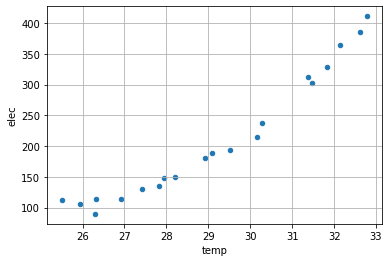

In [5]:
df.plot(kind='scatter', x='temp', y='elec')
plt.grid()
plt.show()

## 최대가능도추정

In [6]:
from scipy.stats import norm

sigma = np.sqrt(np.var(elec))

def L(beta):
  likelihood = norm(beta[1] * temp + beta[0], sigma).pdf(elec)
  return np.sum(-np.log( likelihood ))

In [7]:
from scipy.optimize import minimize

beta = np.array([0, 0])
result = minimize( L, beta )
result.x

array([-1025.18314804,    42.42944756])

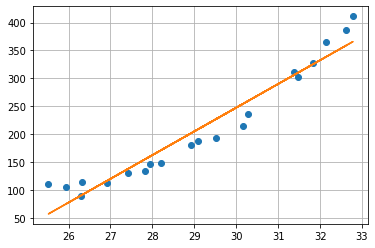

In [8]:
plt.plot( temp, elec, 'o' )
plt.plot( temp, 42.42944756 * temp + -1025.18314804)

plt.grid()
plt.show()

## 최소제곱추정
- 선형성 가정

$$
  f(x) = \beta_0 + \beta_1 x + \epsilon
$$

- 최소제곱추정에 의해서 오차함수는 다음과 같이 정의

$$
  E(a, b) = \sum_{i=0}^n (y_i - (\beta_0 + \beta_1 x_i) )^2
$$

In [4]:
def error(beta):
  yhat = beta[0] + beta[1] * temp
  return np.sum( (elec - yhat) ** 2 )

In [10]:
beta = [ 0, 0 ]
result = minimize( error, beta )
result.x

array([-1025.12948367,    42.42761693])

### 경사하강법을 통한 추정

$$
  x^{(k+1)} = x^{(k)} - \alpha \nabla f(x^{(k)})
$$

In [11]:
def grad_fa(beta):
  return np.sum(-2 * temp * (-beta[1] * temp - beta[0] + elec))

def grad_fb(beta):
  return np.sum(2 * beta[1] * temp + 2 * beta[0] - 2 * elec)

In [ ]:
w = np.array( [ 0, 0 ] )
lr = 0.00001
maxIter = 2000000

f = []
for _ in range(maxIter):
  f.append( error(w) )
  grad = np.array( [ grad_fb(w), grad_fa(w) ] )
  w1 = w - lr * grad
  w = w1

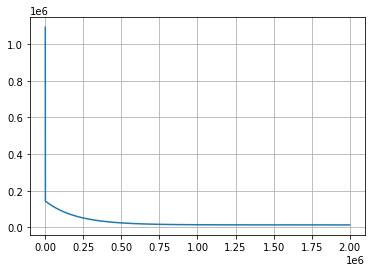

In [ ]:
plt.plot( f )
plt.grid()
plt.show()

In [ ]:
w

array([-1017.85929543,    42.17958362])

### 비선형 모델
- 2차 함수를 적용한다면 아래와 같은 함수를 가정할 수 있다. 

$$
  f(x) = \beta_0 + \beta_1x + \beta_2x^2
$$

- 그럼 오차함수도 다음과 같이 정의될 수 있다.

$$
  E(\beta_0, \beta_1, \beta_2) = \sum(y - (\beta_0 + \beta_1x + \beta_2x^2))^2
$$

In [12]:
df['temp2'] = df['temp'] ** 2
df

,elec,temp,temp2
0,111.67,25.52,651.2704
1,105.82,25.95,673.4025
2,89.57,26.30,691.6900
3,114.05,26.33,693.2689
4,113.60,26.91,724.1481
5,130.59,27.42,751.8564
6,135.12,27.83,774.5089
7,147.28,27.95,781.2025
8,149.09,28.20,795.2400
9,180.60,28.92,836.3664


In [ ]:
def error(beta):
  yhat = beta[0] + beta[1] * df['temp'] + beta[2] * df['temp2']
  return np.sum( (df['elec'] - yhat) ** 2 )

def grad_b0(beta):
  return np.sum( 2 * beta[0] + 2 * beta[1] * df['temp'] + 2 * beta[2] * df['temp2'] - 2 * elec )

def grad_b1(beta):
  return np.sum( -2 * df['temp'] * (-beta[0] - beta[1] * df['temp'] - beta[2] * df['temp2'] + elec) )

def grad_b2(beta):
  return np.sum( -2 * df['temp2'] * (-beta[0] - beta[1] * df['temp'] - beta[2] * df['temp2'] + elec) )

In [ ]:
w = np.array( [ 0, 0, 0 ] )
lr = 0.000000001
maxIter = 1000

f = []
for _ in range(maxIter):
  f.append( error(w) )
  grad = np.array( [ grad_b0(w), grad_b1(w), grad_b2(w) ] )
  w1 = w - lr * grad
  w = w1

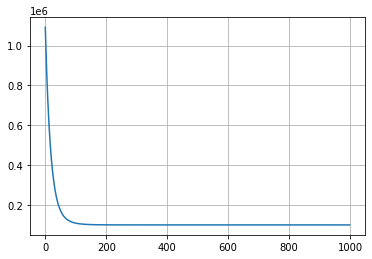

In [ ]:
plt.plot( f )
plt.grid()
plt.show()

In [ ]:
beta = np.array([0, 0, 0])
result = minimize( error, beta )
result.x

array([3647.24199537, -279.29392256,    5.50378104])

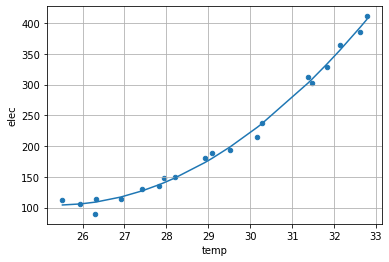

In [ ]:
w = result.x
df.plot(kind='scatter', x='temp', y='elec')
plt.plot( df['temp'], w[0] + w[1] * df['temp'] + w[2] * df['temp2'] )
plt.grid()
plt.show()

## 실습2
- 무어의 법칙

In [2]:
rawData = np.load('/content/drive/MyDrive/멀티캠퍼스/data/moore.npz')
x = rawData['X']
y = rawData['y']

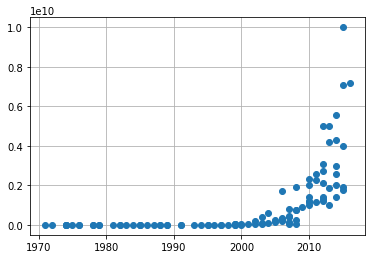

In [3]:
plt.plot(x, y, 'o')
plt.grid()
plt.show()

In [5]:
def error(beta):
  yhat = beta[0] + beta[1]*x
  return np.sum((y - yhat)**2)

In [7]:
from scipy.optimize import minimize

beta = [0, 0]
result = minimize(error, beta)
result.x

array([     0.        , 524287.96260122])

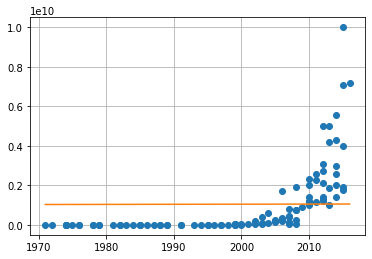

In [10]:
plt.plot(x, y, 'o' )
plt.plot(x, 524287.96260122 * x)

plt.grid()
plt.show()

In [ ]:
def error(beta):
  return np.sum( (y - np.exp(beta[0] + beta[1] * x)) ** 2 )

def grad_b0(beta):
  return np.sum( -2 * (y - np.exp(beta[0] + beta[1] * x) * np.exp(beta[0] + beta[1] * x))  )

def grad_b1(beta):
  return np.sum( -2 * x * (y - np.exp(beta[0] + beta[1] * x) * np.exp(beta[0] + beta[1] * x))  )

In [ ]:
w = np.array( [ 0, 0 ] )
lr = 0.0000000000000000001
maxIter = 1000000

f = []
for _ in range(maxIter):
  f.append( error(w) )
  grad = np.array( [ grad_b0(w), grad_b1(w) ] )
  w1 = w - lr * grad
  w = w1

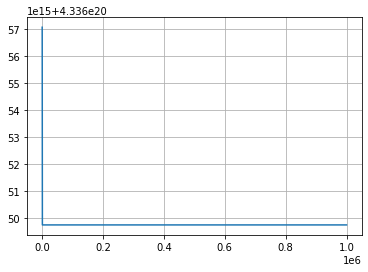

In [ ]:
plt.plot( f )
plt.grid()
plt.show()

In [ ]:
beta = [ 0, 0 ]
result = minimize( error, beta )
result.x

array([0., 0.])

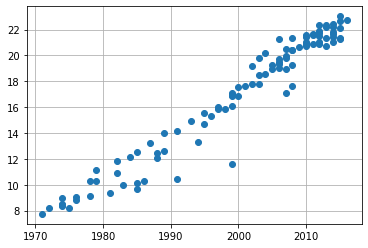

In [ ]:
logY = np.log(y)
plt.plot(x, logY, 'o')
plt.grid()
plt.show()

In [ ]:
def error(beta):
  yhat = beta[0] + beta[1] * x
  return np.sum( (logY - yhat) ** 2 )

def grad_b0(beta):
  return np.sum(-2 * x * (-beta[1] * x - beta[0] + logY))

def grad_b1(beta):
  return np.sum(2 * beta[1] * x + 2 * beta[0] - 2 * logY)

In [ ]:
w = np.array( [ 0, 0 ] )
lr = 0.000000001
maxIter = 1000000

f = []
for _ in range(maxIter):
  f.append( error(w) )
  grad = np.array( [ grad_b0(w), grad_b1(w) ] )
  w1 = w - lr * grad
  w = w1

In [ ]:
w

array([1.46079446e+01, 1.18867823e-03])

In [ ]:
beta = [0, 0]
result = minimize( error, beta )
result.x

array([-6.84654467e+02,  3.50870636e-01])

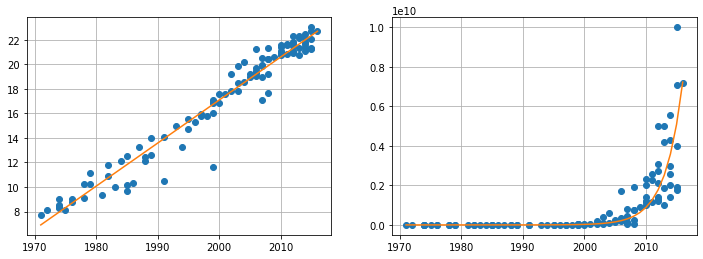

In [ ]:
w = result.x
plt.figure( figsize=(12,4) )

plt.subplot(1, 2, 1)
plt.plot(x, logY, 'o')
plt.plot(x, w[0] + w[1] * x )
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(x, y, 'o')
plt.plot(x, np.exp(w[0] + w[1] * x) )
plt.grid()

plt.show()

# 모형의 평가
- 회귀모형과 같은 경우는 크게 두 가지 방법으로 평가
  1. 정확도
  2. 오차

## 정확도

### 모형의 정확도
- 결정계수(R-squared)
  - 만들어진 모형이 주어진 자료를 얼마나 잘 설명하는지를 나타내는 지표
  - 일반적으로, $R^2$, r2 score 라고 표현을 합니다. 

- 결정계수를 구하는 공식은 아래와 같습니다. 

$$
  R^2 = 1 - \frac{\sum(y - \hat y)^2}{\sum(y - \bar y)^2}
$$

- 표본평균과 자료의 차이(편차)에 대한 자료와 예측값의 차이의 비율
  - 변동성에 대한 오차의 비율이 작으면 작을수록 주어진 자료를 잘 설명하고 있다고 판단

In [ ]:
yhat = w[0] + w[1] * x
r2 = 1 - np.sum(np.square(logY-yhat)) / np.sum(np.square(logY-np.mean(logY)))
r2

0.9529440539558623

### 수정된 결정계수
- 결정계수는 변수가 많아질수록 정확도가 높아지는 경향이 있습니다.
  - 변수가 추가될 수록 과적합이 발생할 확률도 같이 높아지게 됩니다.
- 변수가 추가될 수록, 패널치를 부과해서, 오히려 정확도를 더 낮추게 됩니다.

$$
  Adjusted R^2 = 1 - \frac{(1-R^2)(N-1)}{N - p - 1}
$$

- Adj. R2는 항상 R2보다 같거나 작은 값이 나오게 됩니다.

In [ ]:
x.shape

(102,)

In [ ]:
def adjustedR2( r2, x ):
  if x.ndim == 1: p, n = 1, x.shape[0]
  else: p, n = x.shape[1], x.shape[0]
  return 1 - (1-r2) * (n-1) / (n-p-1)

In [ ]:
adjustedR2( r2, x )

0.952473494495421

## 오차
- 오차와 잔차는 다른 개념입니다. 
  - 실제로 오차항을 알수는 없기 때문에, 잔차를 오차와 같은 개념으로 사용

### MSE(Mean Squared Error)
- 최소제곱추정 방법에서 평균을 취해준 방식
  - 오차들의 평균
  - 오차들의 평균이 작으면 작을 수록 좋은 모형이라고 평가

In [ ]:
yhat = w[0] + w[1] * x
np.mean( np.square(logY - yhat) )

1.0473960808896028

### MAD(Mean Absolute Deviation)
- 평균절대오차
  - 잔차들의 절대값의 합을 자료의 개수로 나눈 값

In [ ]:
yhat = w[0] + w[1] * x
np.mean( np.abs(logY - yhat) )

0.7086863483589458

### 시각화
- 일반적으로 오차항은 정규분포임을 가정
- 잔차들이 정규분포 형태를 가진다면, 가장 이상적인 형태로 판단
  - 잔차들이 정규분포 형태가 아니라면, 아직 반영하지 못한 것들이 남아 있음을 의미
- 잔차는 예측값과 실제값의 차이를 의미

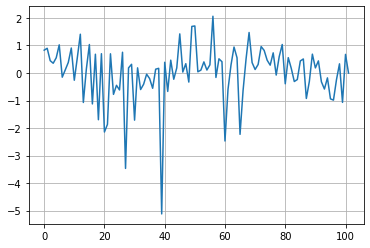

In [ ]:
residual = logY - yhat
plt.plot(residual)
plt.grid()
plt.show()

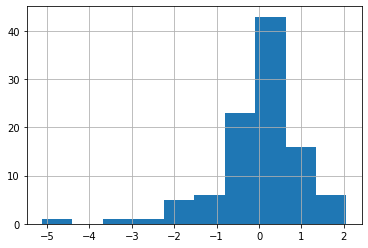

In [ ]:
residual = logY - yhat
plt.hist(residual)
plt.grid()
plt.show()

# 일반화선형모형이란? 
- 선형회귀를 확장한 개념
  - 선형회귀는 항상 사용할 수 없습니다.
  - 몇가지의 특별한 경우를 가정하게 됩니다.
    1. 자료의 관계가 선형적임을 가정
    2. 오차항의 분포는 정규분포임을 가정
    3. 그렇기 때문에 타겟변수 또한, 정규분포임을 가정

- 일반화선형모형은 특수한 경우를 제외하고, 선형회귀를 할 수 있도록, `일반화` 시킨 개념
  - 보다, 일반적인 예측을 가능하게 해줍니다. 
  - 타겟변수가 연속형이 아니어도 사용할 수 있습니다.
  - 타겟변수가 범주형(이산형)인 경우에 많이 사용을 하게 됩니다. 
  - 이러한 모델을 `분류 모델`이라고 부릅니다.

> 타겟변수가 범주형(이산형)인 경우에 선형회귀를 할 수 없기 때문에, 일반화선형모형을 주로 사용을 하게 되는데, 일반화선형모형이 분류모형으로만 사용되지는 않습니다. 

## 실습예제
- 그리기 쉽게 적당한 데이터를 샘플링 해보도록 합니다.
- 아이스크림 문제와 비슷한 문제를 하나 가정
  - 자료의 개수가 6개이고, 변수가 2개인 어떤 자료를 샘플링
  - 이런 경우에는 선형회귀를 적용해볼 수 없습니다.

In [ ]:
from sklearn import datasets

In [ ]:
x, y = datasets.make_classification(
  n_samples = 6, n_features= 2, n_classes=2, random_state=25,
  n_informative=1, n_redundant=0, n_clusters_per_class=1,
)

In [ ]:
sample = pd.DataFrame( np.c_[y, x], columns=['y', 'x1', 'x2'] )
sample

,y,x1,x2
0,1.0,-0.232312,1.073766
1,1.0,-1.334661,1.027741
2,1.0,2.152957,1.119398
3,0.0,-0.920734,-1.310594
4,0.0,-2.053231,-0.915553
5,0.0,0.868583,-0.620115


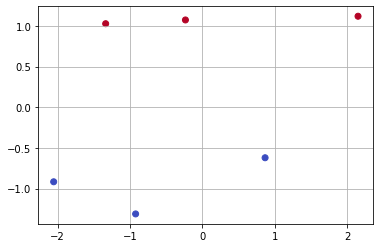

In [ ]:
plt.scatter( sample['x1'], sample['x2'], c=sample['y'], cmap='coolwarm' )
plt.grid()
plt.show()

## 다음중 더 좋은 모델은?

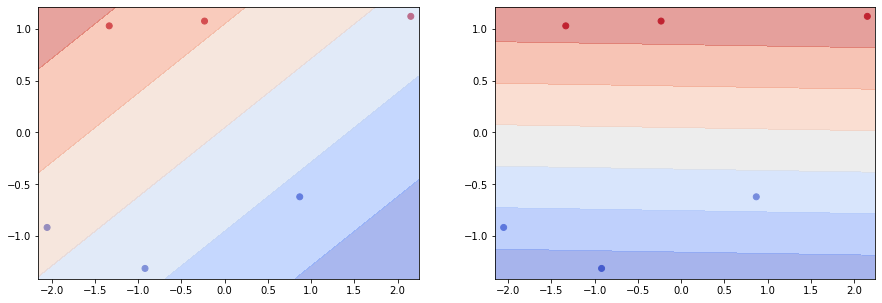

In [ ]:
xy1, xy2 = np.meshgrid(
    np.arange(x[:,0].min() - 0.1, x[:,0].max() + 0.1, 0.01), 
    np.arange(x[:,1].min() - 0.1 , x[:,1].max() + 0.1 , 0.01)
)

beta = np.array([-10, 15])
xx = np.c_[xy1.flatten(), xy2.flatten()]
yhat = np.dot(xx, beta) + -0.7
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(x[:,0], x[:,1], c = y, cmap='coolwarm')
plt.contourf(xy1, xy2, yhat.reshape(xy1.shape), cmap='coolwarm', alpha=0.5)

beta = np.array([0.2, 15])
xx = np.c_[xy1.flatten(), xy2.flatten()]
yhat = np.dot(xx, beta) + -0.7
plt.subplot(1, 2, 2)
plt.scatter(x[:,0], x[:,1], c = y, cmap='coolwarm')
plt.contourf(xy1, xy2, yhat.reshape(xy1.shape), cmap='coolwarm', alpha=0.5)

plt.show()

- 왼쪽 모형보다 오른쪽 모형이 맞춘개수가 더 많다. 
- 오른쪽 모형이 더 좋은 모형이다.

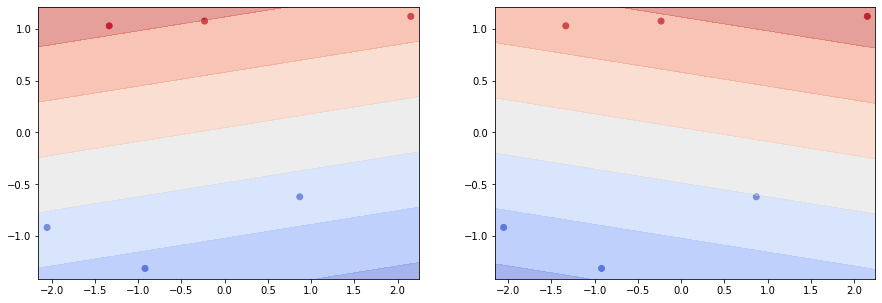

In [ ]:
xy1, xy2 = np.meshgrid(
    np.arange(x[:,0].min() - 0.1, x[:,0].max() + 0.1, 0.01), 
    np.arange(x[:,1].min() - 0.1 , x[:,1].max() + 0.1 , 0.01)
)

beta = np.array([-2, 15])
xx = np.c_[xy1.flatten(), xy2.flatten()]
yhat = np.dot(xx, beta) + -0.7
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(x[:,0], x[:,1], c = y, cmap='coolwarm')
plt.contourf(xy1, xy2, yhat.reshape(xy1.shape), cmap='coolwarm', alpha=0.5)

beta = np.array([2, 15])
xx = np.c_[xy1.flatten(), xy2.flatten()]
yhat = np.dot(xx, beta) + -0.7
plt.subplot(1, 2, 2)
plt.scatter(x[:,0], x[:,1], c = y, cmap='coolwarm')
plt.contourf(xy1, xy2, yhat.reshape(xy1.shape), cmap='coolwarm', alpha=0.5)

plt.show()

- 틀린 개수가 동일
- 어떤 모델이 더 좋은 모델인지 판단할 수 없다.
- 그렇기 때문에, 틀린 갯수만 가지고는 판단할 수 없다. 
  - continuos(연속적인) 형태의 평가 방식이 필요
  - 확률적 개념을 도입(최대 가능도 추정)

## 라이브러리는 어떻게?

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model = LogisticRegression()
model.fit(sample[['x1', 'x2']], sample['y'])

LogisticRegression()

In [ ]:
pd.DataFrame( np.c_[ y, model.predict_proba( sample[['x1', 'x2']] ) ], columns=['y', '0', '1'] )

,y,0,1
0,1.0,0.224322,0.775678
1,1.0,0.265428,0.734572
2,1.0,0.160384,0.839616
3,0.0,0.861946,0.138054
4,0.0,0.819000,0.181000
5,0.0,0.668922,0.331078


# 선형회귀의 일반화
- 선형회귀를 할 수 있도록 최대가능도추정을 이용해서 일반화 하는 방법을 생각
- 주어진 샘플은 정규분포가 아닌 **베르누이 분포**를 따르는 모형을 생각해볼 수 있습니다. 

$$
  y \sim Ber( ax + b )
$$

- 적절하게 0과 1사이의 값으로 변환해 주는 방법을 생각해볼 수 있습니다.
  - 정규분포의 누적분포함수를 생각해볼 수 있습니다.
  - 머신러닝에서는 `logit` 함수라고 합니다.
  - 딥러닝에서는 `sigmoid` 함수라고 합니다.
  - 그냥 전부 정규분포의 누적분포함수 입니다.

## logit function

$$
  f(x) = \frac{1}{1 + e^{-x}}
$$

In [ ]:
def logit(x):
  return 1 / (1 + np.exp(-x))

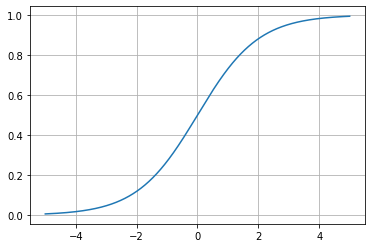

In [ ]:
x = np.linspace(-5, 5, 1000)
plt.plot(x, logit(x))
plt.grid()
plt.show()

로짓함수는 정규분포의 누적분포함수와 같습니다.

## 선형회귀의 일반화란? 
- 다음과 같은 수학적 모델을 이용하면, **선형회귀**라고 합니다. 

$$
  f(x) = ax + b
$$

- 이러한 수학적 모델에 적당한 함수 F를 도입함으로써, 보다 일반적인 예측을 가능하게 해준다.
  - 이 적당한 함수 F는 확률적 계산을 가능

$$
  f(x) = F(ax + b)
$$

- 주어진 샘플에서는 다음과 같이 정의해볼 수 있습니다. 

$$
  y \sim Ber( logit(ax + b) )
$$